# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

['resized-2015-2019-blindness-detection-images', 'pretrained-pytorch-models', 'aptos-15-pretrained-resnet101', 'aptos2019-blindness-detection', 'fastai-pretrained-models', 'efficientnet-pytorch']
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=b08e8920ca56faf3dfa82b4e97718b224aed9149fab5af12bea636775bcc5517
  Stored in directory: /tmp/.cache/pip/wheels/27/56/13/5bdaa98ca8bd7d5da65cc741987dd14391b87fa1a09081d17a
Successfully built efficientnet-pytorch


In [2]:
import fastai
from fastai.vision import *
fastai.__version__

'1.0.57'

In [3]:
from torch.nn import CrossEntropyLoss

# Copy Pretrained Weights to Where Pytorch Will Look

In [4]:
# copy pretrained weights for resnet50 to the folder fastai will search by default
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp /kaggle/input/fastai-pretrained-models/* /tmp/.cache/torch/checkpoints/
!ls /tmp/.cache/torch/checkpoints/

densenet121-a639ec97.pth  resnet50-19c8e357.pth
densenet169-b2777c0a.pth  squeezenet1_0-a815701f.pth
densenet201-c1103571.pth  squeezenet1_1-f364aa15.pth
resnet101-5d3b4d8f.pth	  vgg16_bn-6c64b313.pth


# Data Loading

## Read The CSVs

In [5]:
ls /kaggle/input/aptos2019-blindness-detection/

sample_submission.csv  test.csv  test_images/  train.csv  train_images/


In [6]:
!ls -1 /kaggle/input/resized-2015-2019-blindness-detection-images/labels/

testImages19.csv
testLabels15.csv
trainLabels15.csv
trainLabels19.csv


In [7]:
train_label_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')

In [8]:
train_label_19 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv')

In [9]:
test_label_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')

In [10]:
train_label_15.level.value_counts()

0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

In [11]:
value_counts = np.array(train_label_15.level.value_counts(sort=False), dtype=np.float32)

In [12]:
value_counts

array([25810.,  2443.,  5292.,   873.,   708.], dtype=float32)

In [13]:
train_label_15.columns

Index(['image', 'level'], dtype='object')

In [14]:
train_label_19.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [15]:
train_label_19.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [16]:
test_label_15.level.value_counts()

0    39533
2     7861
1     3762
3     1214
4     1206
Name: level, dtype: int64

In [17]:
test_label_15.columns

Index(['image', 'level', 'Usage'], dtype='object')

## Load Data

In [18]:
aptos19_stats = ([0.42, 0.22, 0.075], [0.27, 0.15, 0.081])

In [19]:
import glob
import cv2
import numpy as np

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

class APTOSImageList(ImageList):
    def open(self, fn:PathOrStr) -> Image:
        img = circle_crop(str(fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        return Image(px=pil2tensor(img, np.float32))

path = Path("/kaggle/input/resized-2015-2019-blindness-detection-images")
src = (
    APTOSImageList.from_folder(path, presort=True, recurse=True)
        .filter_by_func(lambda item: item.parts[-2] != "resized test 19")
)

In [20]:
src=src.split_by_valid_func(lambda item: item.parts[-2] == "resized train 19")

## Label the Data

In [21]:
train_label_15_dict = dict(zip(list(train_label_15.image), list(train_label_15.level)))

In [22]:
train_label_19_dict = dict(zip(list(train_label_19.id_code), list(train_label_19.diagnosis)))

In [23]:
test_label_15_dict = dict(zip(list(test_label_15.image), list(test_label_15.level)))

In [24]:
def label_func(item):
    if item.parts[-2] == "resized train 15":
        return train_label_15_dict[item.stem]
    elif item.parts[-2] == "resized test 15":
        return test_label_15_dict[item.stem]
    elif item.parts[-2] == "resized train 19":
        return train_label_19_dict[item.stem]
    else:
        assert(False)

In [25]:
src = src.label_from_func(label_func)

## Transformations

In [26]:
tfms = ([dihedral(), 
         contrast(scale=(1.5, 3.0)), 
         brightness(change=(0.5, 0.60)), 
         rotate(degrees=(-180, 180))], 
        [contrast(scale=(1.5, 3.0)), 
         brightness(change=(0.5, 0.60)),])

## Create Databunch

In [27]:
data = (
    src.transform(tfms,size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
    .databunch(bs=16)
    .normalize(aptos19_stats)
)

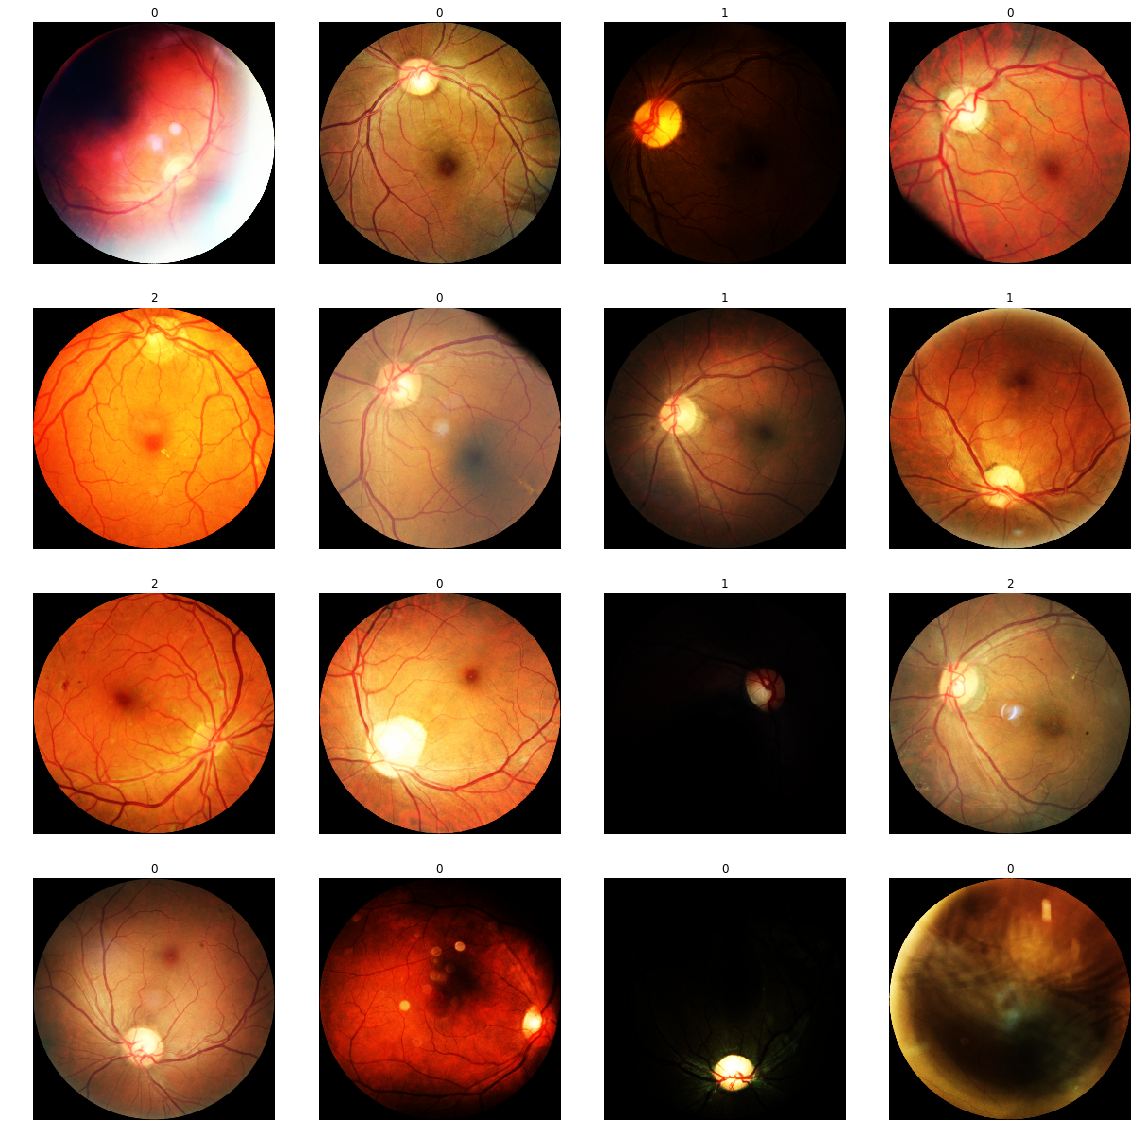

In [28]:
data.show_batch()

In [29]:
model_path='/kaggle/input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'

In [30]:
def EfficientNetB5(pretrained=True):
    """Constructs a EfficientNet model for FastAI.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = EfficientNet.from_name('efficientnet-b5', override_params={'num_classes':5})

    if pretrained:
        model_state = torch.load(model_path)
        # load original weights apart from its head
        if '_fc.weight' in model_state.keys():
            model_state.pop('_fc.weight')
            model_state.pop('_fc.bias')
            res = model.load_state_dict(model_state, strict=False)
            assert str(res.missing_keys) == str(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
        else:
            # A basic remapping is required
            from collections import OrderedDict
            mapping = { i:o for i,o in zip(model_state.keys(), model.state_dict().keys()) }
            mapped_model_state = OrderedDict([
                (mapping[k], v) for k,v in model_state.items() if not mapping[k].startswith('_fc')
            ])
            res = model.load_state_dict(mapped_model_state, strict=False)
            print(res)
    return model

In [31]:
model = EfficientNetB5(pretrained=True)

In [32]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3., reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = LabelSmoothingCrossEntropy(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = ((1 - pt)**self.gamma) * CE_loss
        if self.reduction == 'sum':
            return F_loss.sum()
        elif self.reduction == 'mean':
            return F_loss.mean()

In [33]:
kappa = KappaScore()
kappa.weights = "quadratic"
precision = Precision(average="macro")
recall = Recall(average="macro")
loss_func = FocalLoss()

In [34]:
learn = Learner(data, model,
                    loss_func=loss_func,metrics=[kappa,accuracy],
                    model_dir='/kaggle/working')

In [35]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 257, 257]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 128, 128]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 130, 130]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 128, 128]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 128, 128]       0          False     
_________________________________________________

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-04
Min loss divided by 10: 2.09E-04


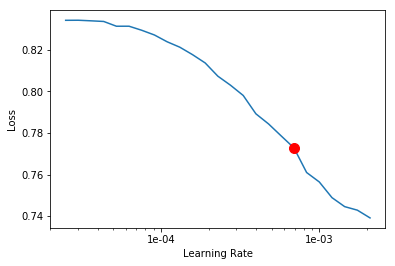

In [37]:
# Find a good learning rate
learn.recorder.plot(30,29,suggestion=True)

In [38]:
lr = 1.1e-3
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,kappa_score,accuracy,time


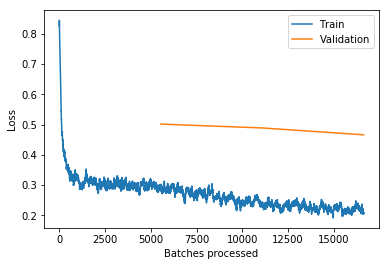

In [39]:
learn.recorder.plot_losses()

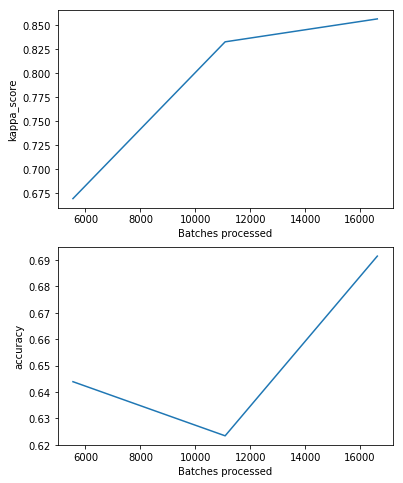

In [40]:
learn.recorder.plot_metrics()

In [41]:
learn.save('/kaggle/working/pretrained_focal_smooth_gen1_effi5')